# VANILLA GAN - MNIST

## IMPORTS

In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import os
import time

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [3]:
# torch.cuda.get_device_name(0)

## HYPERPARAMETERS

In [4]:
dataroot = '../storage/data/mnist_png/'
saveroot = '../storage/GAN_Images/'
test_number = 'Test_1'

batch_size = 32
workers = 4
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(1),
    torchvision.transforms.ToTensor()
])

nz = 100

lr = 0.0001
betas = (0,0.9)
Lambda_value = 10

num_epochs = 10
num_steps = 1000
k = 5

## DATASET

In [5]:
ds = torchvision.datasets.ImageFolder(dataroot+'training', transforms)

In [6]:
len(ds)

60000

In [7]:
dl = torch.utils.data.DataLoader(ds, batch_size, shuffle=True, num_workers=workers, pin_memory=True)

## DATA ANALYSIS

In [8]:
for data in (dl):
    print(data[0].shape, data[1].shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


## MODEL

In [9]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(nz, 256),
            torch.nn.LeakyReLU(0.2)
        )
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(256, 512),
            torch.nn.LeakyReLU(0.2)
        )
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(0.2)
        )
        self.fc4 = torch.nn.Sequential(
            torch.nn.Linear(1024, 784),
            torch.nn.Tanh()
        )
        
    def forward(self, x):
        # x.shape = batch_size x nz
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [10]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(784 , 1024),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3)
        )
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024 , 512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3)
        )
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(512 , 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3)
        )
        self.fc4 = torch.nn.Sequential(
            torch.nn.Linear(256 , 1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        # (batch_size, 784) or (batch_size, 1, 28, 28)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [11]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [12]:
for params in discriminator.parameters():
    print(params.shape)

torch.Size([1024, 784])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([1, 256])
torch.Size([1])


## LOSS AND OPTIMIZATION

In [13]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr, betas) ## WGAN-GP ##
opt_g = torch.optim.Adam(generator.parameters(), lr, betas) ## WGAN-GP ##
criterion = torch.nn.BCELoss() ## WGAN-GP ##

In [14]:
real_labels = torch.ones((batch_size, 1)).to(device)
fake_labels = torch.zeros((batch_size, 1)).to(device) ## WGAN-GP ##
fixed_noise = torch.randn(batch_size, nz).to(device)

In [15]:
# Gradient Penalty Loss

'''
x: real data
y: generated data


torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True, allow_unused=False)
Computes and returns the sum of gradients of outputs w.r.t. the inputs.
'''
def calcGradientPenalty(x, y):

  # inspect inputs dimensions
  # print(x.shape, y.shape)
  # torch.Size([64, 1, 784]) torch.Size([64, 784])
  # remove the excess dimension
  x = x.view(x.size(0), -1)
  

  # combine real and generated images
  alpha = torch.rand(x.shape).to(device)
  interpolated = alpha * x + (1 - alpha) * y
  
  # convert combination to torch variable with gradients
  var_interpolated = torch.autograd.Variable(
      interpolated, requires_grad=True).to(device)

  # pass combination to the discriminator
  outputs = discriminator(var_interpolated)

  # find the gradients of the inputs
  gradients = torch.autograd.grad(
      outputs=outputs,
      inputs=var_interpolated,
      grad_outputs=torch.ones_like(outputs).to(device),
      retain_graph=True,
      create_graph=True,
      only_inputs=False,
      allow_unused=False
  )[0]

  # calculate the mean norm of the gradients
  grad_norm = gradients.norm(2, dim=1).mean()

  # calculate the deviation from the value one
  loss = (grad_norm - 1) ** 2

  # return the gradient penalty
  return loss

## PRE-TRAIN RUN

In [16]:
with torch.no_grad():
    #REAL BATCH
    for xb, _ in dl:
        sample = xb.to(device)
        break
    print("Real Shape:",sample.shape)
    out = discriminator(sample)
    print("Discriminator Out:",out.shape)
    loss = criterion(out, real_labels)
    print("Loss:",loss)
    #FAKE BATCH
    sample = generator(fixed_noise)
    print("Fake Shape:",sample.shape)
    out = discriminator(sample)
    print("Discriminator Out:",out.shape)
    loss = criterion(out, real_labels)
    print("Loss:",loss)

Real Shape: torch.Size([32, 1, 28, 28])
Discriminator Out: torch.Size([32, 1])
Loss: tensor(0.6968, device='cuda:0')
Fake Shape: torch.Size([32, 784])
Discriminator Out: torch.Size([32, 1])
Loss: tensor(0.7036, device='cuda:0')


## TRAIN

In [17]:
def train_discriminator(images):
    opt_d.zero_grad()
    
    real_images = images.to(device)
    fake_images = generator(torch.randn(batch_size, nz).to(device))
    
    real_out = discriminator(real_images)
    fake_out = discriminator(fake_images)
    
    real_loss = criterion(real_out, real_labels)
    fake_loss = criterion(fake_out, fake_labels)
    gan_loss = fake_loss - real_loss
    
    ## WGAN-GP ##
    gradient_penalty = calcGradientPenalty(real_images, fake_images)
    
    loss = gan_loss + Lambda_value * gradient_penalty
    
    loss.backward()
    opt_d.step()
    
    return loss

In [18]:
def train_generator(images):
    opt_g.zero_grad()
    
    real_images = images.to(device)
    fake_images = generator(torch.randn(batch_size, nz).to(device))
    
    out = discriminator(fake_images)
    
    ## WGAN-GP ##
    gan_loss = criterion(out, real_labels)
    
    gradient_penalty = calcGradientPenalty(real_images, fake_images)
    
    loss = gan_loss + Lambda_value * gradient_penalty
    loss.backward()
    opt_g.step()
    
    return loss

In [19]:
start_time = time.time()
loss_D = []
loss_G = []

for epoch in range(num_epochs):
    epoch += 1
    loss_d = 0.0
    loss_g = 0.0
    
    for i,(images,_) in enumerate(dl):
        if i == num_steps:
            break
            
        for _ in range(k):
            loss_d += train_discriminator(images)
            opt_d.step()
        loss_g += train_generator(images)
        opt_g.step()
    loss_D.append(loss_d / k / i)
    loss_G.append(loss_g / i)
    
    print(f'{epoch}/{num_epochs} | loss_d: {loss_d/k/i} | loss_g: {loss_g/i} | Time: {time.time() - start_time:.0f} sec')
    if epoch%10==0:
        sample = generator(fixed_noise).detach()
        grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=8, pad_value=1, normalize=False)   
        torchvision.utils.save_image(grid.detach().cpu(), os.path.join(saveroot, '20210126_MNIST_WGAN_GP_{}_{}.jpg'.format(str(test_number), str(epoch).zfill(3))))

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:130: UserWarning: only_inputs argument is deprecated and is ignored now (defaults to True). To accumulate gradient for other parts of the graph, please use torch.autograd.backward.
  warnings.warn("only_inputs argument is deprecated and is ignored now "


1/10 | loss_d: -35.44091796875 | loss_g: 4.295434474945068 | Time: 71 sec
2/10 | loss_d: -27.207073211669922 | loss_g: 5.178190231323242 | Time: 145 sec
3/10 | loss_d: -27.093839645385742 | loss_g: 5.022879123687744 | Time: 218 sec
4/10 | loss_d: -29.01560401916504 | loss_g: 4.832801342010498 | Time: 291 sec
5/10 | loss_d: -28.99791145324707 | loss_g: 4.5223588943481445 | Time: 363 sec
6/10 | loss_d: -30.0228271484375 | loss_g: 4.130516052246094 | Time: 436 sec
7/10 | loss_d: -30.90118980407715 | loss_g: 4.31961727142334 | Time: 509 sec
8/10 | loss_d: -31.234460830688477 | loss_g: 4.21400785446167 | Time: 583 sec
9/10 | loss_d: -33.00732421875 | loss_g: 4.117537498474121 | Time: 658 sec
10/10 | loss_d: -32.86235427856445 | loss_g: 4.160242080688477 | Time: 733 sec


## TEST

## EVALUATE

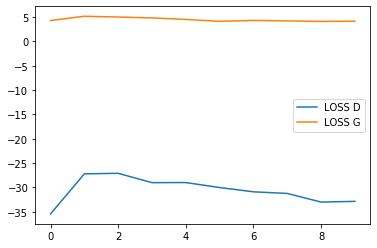

In [20]:
plt.figure()

plt.plot(loss_D, label='LOSS D')
plt.plot(loss_G, label='LOSS G')
plt.legend()
plt.savefig('./20210126_MNIST_WGAN_GP_{}'.format(test_number))
plt.show()

## SAVE/ LOAD

In [21]:
torch.save(generator.state_dict(), './20210126_MNIST_WGAN_GP_G.pt')
torch.save(discriminator.state_dict(), './20210126_MNIST_WGAN_GP_D.pt')